# Red Light Camera Natural Experiment

This section will feature hypothesis testing for crash data based on the active status of cameras.  
The central focus of this project was to see how the presence of red light cameras affected safety.

Safety can be measured several ways: total crashes, total injuries, count of dangerous crash types.

The city of Chicago government defines their goal as follows:
> "Red Light Camera Enforcement is designed to increase safety on Chicago streets by reducing the most dangerous types of crashes at intersections. The different types of crashes between vehicles are rear end, side swipe, angle, and head on. While all crashes are potentially hazardous, Red Light cameras are designed to reduce angle (or “t-bone”) crashes because of their extreme danger to those involved. As individuals comply with traffic signals, serious crashes and injuries reduce significantly. Chicago began its red light camera program 2003 with enforcement at two intersections: Peterson and Western and 55th and Western. In subsequent years, additional intersections have been added based on crash frequency/severity. At most Red Light Camera intersections, two approaches are monitored. However, CDOT posts signs at all four approaches identifying the intersection as photo-enforced." https://www.chicago.gov/city/en/depts/cdot/supp_info/red-light_cameraenforcement.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from modules.myfuncs import *
import warnings
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.power import TTestIndPower, TTestPower
from scipy.stats import norm


# import dask
# import dask.dataframe as dd

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [3]:
#rlc_df = pd.read_sql_query('''SELECT * FROM daily_violations''', conn)
#ints_df = pd.read_sql_query('''SELECT * FROM intersection_chars''', conn)
#crash_df = pd.read_sql_query('''SELECT * FROM signal_crashes''', conn)


In [4]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('all_days',), ('all_hours',), ('daily_covid',)]
cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_of_occurrence
	-num_u

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [5]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4) * 153 * 24)


4464234.0


## Query my db to get a DataFrame with crashes and intersection
We will be using the number of crashes and injuries to do some t-tests

In [6]:
cam_df = pd.read_sql_query('''
WITH ah AS(
        SELECT *
        FROM all_hours
        ),
         
    cr AS(
        SELECT year,
                month,
                day,
                hour,
                intersection,
                injuries_total,
                injuries_fatal,
                crash_record_id,
                first_crash_type,
                (first_crash_type == 'REAR END') as rear_end,
                (first_crash_type == 'TURNING') as turning,
                (first_crash_type == 'ANGLE') as angle
        FROM signal_crashes
        ),
        
    se AS(SELECT * FROM int_startend)
                                    
        
        
SELECT ah.*,
    SUM(cr.injuries_total) as injuries_total,
    COUNT(cr.crash_record_id) as n_crash,
    SUM(cr.injuries_fatal) as injuries_fatal,
    cr.first_crash_type,
    SUM(cr.rear_end) as rear_end,
    SUM(cr.angle) as angle,
    SUM(cr.turning) as turning,
    se.start,
    se.end
    
FROM ah

LEFT JOIN cr
    ON cr.year = ah.year
    AND cr.month = ah.month
    AND cr.day = ah.day
    AND cr.hour = ah.hour
    AND cr.intersection = ah.intersection  
LEFT JOIN se
    ON se.intersection = ah.intersection
       
WHERE ah.date >= \'2017-09-01\' AND ah.date <= \'2021-02-15\'
  
GROUP BY ah.year, ah.month, ah.day, ah.hour, ah.intersection
ORDER BY ah.year, ah.month, ah.day, ah.hour, ah.intersection
''', conn)

## Preprocess my data

In [8]:
cam_df.first_crash_type.unique()
cam_df['rear_end'].fillna(0, inplace=True)
cam_df['angle'].fillna(0, inplace=True)
cam_df['turning'].fillna(0, inplace=True)
cam_df['injuries_total'].fillna(0, inplace=True)
cam_df['injuries_fatal'].fillna(0, inplace=True)
cam_df.describe()

,year,month,day,hour,rlc_state,injuries_total,n_crash,injuries_fatal,rear_end,angle,turning
count,4.728672e+06,4.728672e+06,4.728672e+06,4.728672e+06,4.728672e+06,4.728672e+06,4.728672e+06,4.728672e+06,4.728672e+06,4.728672e+06,4.728672e+06
mean,2.018879e+03,6.721298e+00,1.565004e+01,1.150000e+01,9.469923e-01,5.418012e-04,1.379457e-03,2.960662e-06,3.542221e-04,1.806004e-04,5.289011e-04
std,1.045469e+00,3.593552e+00,8.809290e+00,6.922187e+00,2.240489e-01,3.524683e-02,3.730297e-02,2.056577e-03,1.886236e-02,1.351601e-02,2.308357e-02
min,2.017000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.018000e+03,3.000000e+00,8.000000e+00,5.750000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.019000e+03,7.000000e+00,1.600000e+01,1.150000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.020000e+03,1.000000e+01,2.300000e+01,1.725000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.021000e+03,1.200000e+01,3.100000e+01,2.300000e+01,1.000000e+00,2.100000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00


#### change my dates to datetime objects
Need to do this so we can do some date calculations to see which entries had the cameras on or off.

In [9]:
cam_df[['date', 'start', 'end']] = cam_df[['date', 'start', 'end']].apply(pd.to_datetime)

In [10]:
cam_df.isna().sum()  # one entry each accident with no violations/vio_date.  Days with no

year                      0
month                     0
day                       0
hour                      0
intersection              0
date                      0
rlc_state                 0
injuries_total            0
n_crash                   0
injuries_fatal            0
first_crash_type    4722182
rear_end                  0
angle                     0
turning                   0
start                     0
end                       0
dtype: int64

Looks like we are missing violations for cameras that are turned off.  Some of these will be our experiment.

In [11]:
print(len(cam_df)) # should be same as all if everything merged properly

print(len(cam_df.intersection.unique()))

4728672
156


### Split my control and experiment groups

In [12]:
all_on = cam_df[cam_df['rlc_state']==1]
all_off = cam_df[cam_df['rlc_state']==0]
print(all_on.n_crash.sum(), all_off.n_crash.sum())

6033 490


Initial look at how cam on/off compares with count of crashes and percent of intersection days with crashes

In [13]:
print('Cameras ON')
print('Crashes: {}, Intersection-Days: {},  Crashes per hour: {:.5f}'.format(all_on.n_crash.sum(), 
                                                                     len(all_on)//24, 
                                                                     all_on.n_crash.sum()/len(all_on),))

print()
print('Cameras OFF')
print('Crashes: {}, Intersection-Days: {},  Crashes per hour: {:.5f}'.format(all_off.n_crash.sum(), 
                                                                     len(all_off)//24, 
                                                                     all_off.n_crash.sum()/len(all_off)))


Cameras ON
Crashes: 6033, Intersection-Days: 186584,  Crashes per hour: 0.00135

Cameras OFF
Crashes: 490, Intersection-Days: 10444,  Crashes per hour: 0.00195


# Hypothesis test with full data set.

We have an experiment and control group as dataframes.  The control is cam_on.
Our null hypothesis is that turning the cameras off at an intersection has no effect on the number of crashes.

We will use an alpha of 0.05 to reject the null hypothesis

In [21]:
# We make two bool series for on and off
np.random.seed(seed=0)

on = all_on['n_crash'].astype(bool)
off = all_off['n_crash'].astype(bool)

In [22]:
def hyp_test(on, off, alpha):
    '''
    Hypothesis testing for camera on and camera off populations
            Parameters:
                    on (Series): Boolean series (crash/no crash)
                    off (Series): Another Boolean Series (crash/no crash)
                    alpha (float): Statistical significance (usually 0.05)

            Returns:
                    z_score (float): z score (std devs)
                    p_val (float): probability of series drawn from same dataset
                    expected_off (float): expected number of off based on the on_rate
    '''
    on_rate = on.mean()
    off_rate = off.mean()
    expected_off = on_rate * len(off)

    print('Cameras ON mean: {:.5f}'.format(on_rate))
    print('Cameras OFF mean: {:.5f}'.format(off_rate))
    print()

    print('Actual with rlc off:', off.sum())
    print('Expected with rlc off: {:.0f}'.format(expected_off))
    n = len(off)
    p = on_rate
    var = n * p * (1-p)
    std = np.sqrt(var)

    print()
    print('Standard deviation: {:.2f}'.format(std))  
    
    z_score = (off.sum() - expected_off)/std
    print('z score: {:.2f}'.format(z_score))
    
    print()
    p_val = stats.norm.sf(z_score) #or 1 - stats.norm.cdf(z_score)
    print('P value: {:.3e}'.format(p_val))
    
    print()
    if p_val < alpha:
        print('REJECT the null hypothesis')
    else: 
        print('DO NOT REJECT the null hypothesis')
        
    return z_score, p_val, expected_off
    
    

    
z, p, expected = hyp_test(on, off, 0.05)

Cameras ON mean: 0.00134
Cameras OFF mean: 0.00194

Actual with rlc off: 487
Expected with rlc off: 336

Standard deviation: 18.32
z score: 8.24

P value: 8.458e-17

REJECT the null hypothesis


We see many more crashes with cameras off.  This is our first indication that red light cameras affect crashes.

Double check using a binomial test and Fischer's Test

In [23]:
# binomial test
pval = stats.binom_test(off.sum(),n=len(off),p=on.mean())
print('Binomial Test pval: {:.2e}'.format(pval))


oddsratio, pvalue = stats.fisher_exact([[on.sum(), len(on)-on.sum()], [off.sum(), len(off)-off.sum()]])
print('Fisher\'s Test pval: {:.2e}'.format(pvalue))

Binomial Test pval: 1.18e-14
Fisher's Test pval: 6.21e-14


We would reject the null hypothesis by any test.  
First indication that red light cameras are statistically significant in reducing crashes.

The odds ratio tells us that the change is 67%

# Hypothesis test with intersections of interest

The previous test may be misleading.  
Only a small percentage of cameras actually have dates where they were turned on/off during the examined time period. It would be more useful to select data only from the intersections of interest to compare like items.

Next, we will select the cameras that have start/end dates within the timeframe Sept-17 to Dec-20.
We can then look at on/off data for those cams only

### Filter the cams of interest

In [24]:
# get cams that have a start date within the investigated period or an end date within it.
select_cams = cam_df[((cam_df['start'] > datetime(2017,9,1)) & (cam_df['end'] > datetime(2017,9,1)))
                     | ((cam_df['end'] < datetime(2021, 1, 1)) & (cam_df['end'] > datetime(2017, 9,1)))]

print(select_cams.intersection.unique())  # 7  total

['FOSTER AND NORTHWEST HIGHWAY' 'FULLERTON AND NARRAGANSETT'
 'HALSTED AND 103RD' 'LAKE AND UPPER WACKER' 'MICHIGAN AND JACKSON'
 'MICHIGAN AND ONTARIO' 'MILWAUKEE AND CENTRAL']


### Test the populations
Null hypothesis is that camera state has no effect.
Alpha is 0.05

In [27]:
off = select_cams[select_cams['rlc_state']==0]
on = select_cams[select_cams['rlc_state']==1]

After filtering out all but the cams of interest, we split into our control experiment again.
This set is much more balanced.

In [28]:
n_on = len(on)
crash_on = on['n_crash']

n_off = len(off)
crash_off = off['n_crash']

z, pval_final, expected = hyp_test(crash_on, crash_off, 0.05)

Cameras ON mean: 0.00081
Cameras OFF mean: 0.00166

Actual with rlc off: 74
Expected with rlc off: 36

Standard deviation: 6.02
z score: 6.28

P value: 1.735e-10

REJECT the null hypothesis


In [30]:
# binomial test
pval = stats.binom_test(crash_off.sum(),n=len(crash_off),p=crash_on.mean())
print('Binomial Test pval: {:.2e}'.format(pval))

# Fisher test
oddsratio, pvalue = stats.fisher_exact([[crash_on.sum(), len(crash_on)-crash_on.sum()], [crash_off.sum(), len(crash_off)-crash_off.sum()]])
print('Fisher\'s Test pval: {:.2e}'.format(pvalue))

Binomial Test pval: 2.84e-08
Fisher's Test pval: 2.39e-06


### Make a binomial distribution plot 
This plot is for presentation to demonstrate the significance of the finding.}

If my camera off crashes were random, the distribution would look like the graph below.
We use the number of observations (cam off) at the probability equal to the 'cam on' mean.

Text(-120, 50, 'Expected Mean = 36.27')

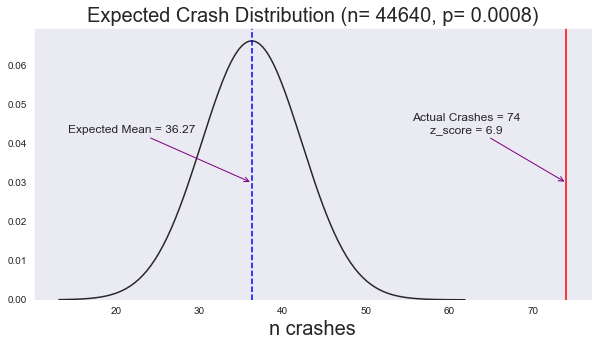

In [33]:


n, p = n_off, crash_on.mean() # number of trials, probability of each trial
actual_crash = off['n_crash'].sum()
dist = np.random.binomial(n, p, 10000)
mean_crash = dist.mean()
plt.figure(figsize=[10,5])
sns.set_style("dark")


ax = sns.distplot(dist, hist=False, fit=norm, kde=False, label='Normal Distribution of Expected Crashes', color='blue')
plt.title('Expected Crash Distribution (n= {}, p= {:.4f})'.format(n, p), fontsize=20)
ax.set_ylim(0)


#plt.axvline(110, 0, 1, color='red')
plt.axvline(actual_crash, 0, 1, color='red', )
plt.axvline(mean_crash, 0, 1, color='blue', linestyle='dashed')

plt.xlabel('n crashes', fontsize=20)

#ax.text(108, 0.045, "Actual n crashes", horizontalalignment='right', size='medium', color='black', weight='semibold')
ax.annotate(s='Actual Crashes = {}\nz_score = {}'.format(actual_crash, 6.9),
            xy=(actual_crash, 0.03),
            xycoords='data',
            fontsize=12,
            xytext=(-100, 50),
            textcoords='offset points',
            horizontalalignment='center',
            arrowprops=dict(arrowstyle='->', color='purple'),  # Use color black

            )   # New param

ax.annotate(s='Expected Mean = {:.2f}'.format(mean_crash),
            xy=(mean_crash, 0.03),
            xycoords='data',
            fontsize=12,
            xytext=(-120, 50),
            horizontalalignment='center',
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='purple'),  # Use color black

            )   # New param

Having a cam on is statistically significant for this group.

There could be another effect.  What if the camera that had the most down time also had more crashes.  That would skew the results dramatically

Another way we could this is by going through every camera of interest or by balancing the number of samples taken from each intersection.



## Hypothesis Testing on Individual Cameras



In [36]:
def get_power(on, off):
    # print out the power and effect for the populations
    power_analysis = TTestIndPower()

    # total days of observations
    observations = len(on) + len(off)
    print('Observations: {}'.format(observations))

    # effect size is measure of effect (small 02, medium )
    effect_size = abs(off.mean() - on.mean())/ on.std()
    print('Effect size: {:.3f}'.format(effect_size) ) # effect size
    power = power_analysis.solve_power(effect_size=effect_size, nobs1=observations, alpha=.05)  # nobs1, alpha, power, effect_size
    print('Power: {:.3f}'.format(power))

print(select_cams.intersection.unique())
print()
print('We have {} intersections of interest.'.format(len(select_cams.intersection.unique())))



['FOSTER AND NORTHWEST HIGHWAY' 'FULLERTON AND NARRAGANSETT'
 'HALSTED AND 103RD' 'LAKE AND UPPER WACKER' 'MICHIGAN AND JACKSON'
 'MICHIGAN AND ONTARIO' 'MILWAUKEE AND CENTRAL']

We have 7 intersections of interest.


In [38]:
off = select_cams[select_cams['rlc_state']==0]
on = select_cams[select_cams['rlc_state']==1]
        

for intersection in select_cams.intersection.unique():
    
    crash_on = on[on['intersection']==intersection]['n_crash']
    crash_off = off[off['intersection']==intersection]['n_crash']

    
    n_on = len(on)
    n_off = len(off)

    
    on_rate = crash_on.mean()
    off_rate = crash_off.mean()
    expected_off = on_rate * n_off
    
    print()
    print('*'*20)
    print(intersection)
    print()
    
    hyp_test(crash_on, crash_off, 0.05)
    print()
    get_power(crash_on, crash_off)
    


********************
FOSTER AND NORTHWEST HIGHWAY

Cameras ON mean: 0.00037
Cameras OFF mean: 0.00000

Actual with rlc off: 0
Expected with rlc off: 0

Standard deviation: 0.54
z score: -0.54

P value: 7.066e-01

DO NOT REJECT the null hypothesis

Observations: 30312
Effect size: 0.019
Power: 0.662

********************
FULLERTON AND NARRAGANSETT

Cameras ON mean: 0.00120
Cameras OFF mean: 0.00163

Actual with rlc off: 2
Expected with rlc off: 1

Standard deviation: 1.21
z score: 0.43

P value: 3.319e-01

DO NOT REJECT the null hypothesis

Observations: 30312
Effect size: 0.012
Power: 0.334

********************
HALSTED AND 103RD

Cameras ON mean: 0.00149
Cameras OFF mean: 0.00159

Actual with rlc off: 46
Expected with rlc off: 43

Standard deviation: 6.56
z score: 0.44

P value: 3.296e-01

DO NOT REJECT the null hypothesis

Observations: 30312
Effect size: 0.003
Power: 0.062

********************
LAKE AND UPPER WACKER

Cameras ON mean: 0.00085
Cameras OFF mean: 0.00162

Actual with r

You can reject the null hypothesis for 2 of 7 intersections. More interesting is that all the expected crashes point in the same direction 

The power was very low on the intersections that could not reject null hypothesis.  These were not a valid test since there was a low probability of getting a result even if the null hypothesis was false.

I am not satisfied with these results.  I would like to build a more robust experiment that pools all of our intersections, but maintains some balance between the different intersections.

## Build a balanced experiment and control
We have an imbalance. Each intersection is imbalanced cam_on/cam_off.  We are unable to use all of the data for this reason. If we lump all of the intersections together, the cams that were primarily on or primarily off will be overrepresented in their respective groups.  

I propose balancing every intersection.  If I only have 100 days with the camera off, I will only take 100 days of data from the camera on data.  We should also control for time of year if possible.  We could take random samples perhaps to minimize this effect. 

In [40]:

def get_balanced_sets(select_cams, target):
    '''
            Parameters:
                    select_cams (DataFrame): df that holds all filtered intersections of interest only
                    target (string): name of column to be returned (i.e. crashes, injuries, etc.)
                    
            Returns:
                    balanced_ints_on (Series): bool series of crash data for dates with cam on
                    balanced_ints_off (Series): bool series of crash data for dates with cam off
    
    '''
    np.random.seed(42)

    balanced_ints_on = pd.Series()
    balanced_ints_off = pd.Series()


    for myint in select_cams['intersection'].unique():
        myint_df = select_cams[select_cams['intersection']==myint]  # get all days regardless of on/off status
        cam_on = myint_df[myint_df.rlc_state==1]
        cam_off = myint_df[myint_df.rlc_state==0]
        cam_on = cam_on.sample(frac=1).reset_index(drop=True)
        cam_off = cam_off.sample(frac=1).reset_index(drop=True)


        balanced_n = min(cam_on.year.count(), cam_off.year.count())  # get the smaller size (control or experiment)
        if balanced_n:
            print('{:>30}: {}'.format(myint, balanced_n))

        # use balanced_n to add same amount to each series
        balanced_ints_on = balanced_ints_on.append(cam_on.iloc[:balanced_n][target])
        balanced_ints_off = balanced_ints_off.append(cam_off.iloc[:balanced_n][target])

    print()
    print(len(balanced_ints_on)//24, 'days of cam on, and', len(balanced_ints_off)//24, 'days of cam off.')
    print(balanced_ints_on.count(), balanced_ints_off.count())
    
    return balanced_ints_on, balanced_ints_off

After building the dataset, we have relatively few rows in each dataset remaining.  We have 7 intersections represented in the set.

In [41]:
target = 'n_crash'

# get dataset
balanced_ints_on, balanced_ints_off = get_balanced_sets(select_cams, target)

# get the t-test results
print("\n\nHypothesis testing results ({})".format(target))
print('*'*40)
results = hyp_test(balanced_ints_on, balanced_ints_off, 0.05)

# check with other metrics
# binomial test
print("\n\nAlternate hypothesis testing results ({})".format(target))
print('*'*40)
pval = stats.binom_test(crash_off.sum(),n=len(crash_off),p=crash_on.mean())
print('Binomial Test pval: {:.2e}'.format(pval))

# Fisher test
oddsratio, pvalue = stats.fisher_exact([[balanced_ints_on.sum(), len(balanced_ints_on)-balanced_ints_on.sum()], 
                                        [balanced_ints_off.sum(), len(balanced_ints_off)-balanced_ints_off.sum()]])

print('Fisher\'s Test pval: {:.2e}'.format(pvalue))

# get power
print("\n\nPower and effect ({})".format(target))
print('*'*40)
get_power(balanced_ints_on, balanced_ints_off)


  FOSTER AND NORTHWEST HIGHWAY: 792
    FULLERTON AND NARRAGANSETT: 1224
             HALSTED AND 103RD: 1344
         LAKE AND UPPER WACKER: 4320
          MICHIGAN AND JACKSON: 3936
          MICHIGAN AND ONTARIO: 3936
         MILWAUKEE AND CENTRAL: 1464

709 days of cam on, and 709 days of cam off.
17016 17016


Hypothesis testing results (n_crash)
****************************************
Cameras ON mean: 0.00082
Cameras OFF mean: 0.00165

Actual with rlc off: 28
Expected with rlc off: 14

Standard deviation: 3.74
z score: 3.74

P value: 9.085e-05

REJECT the null hypothesis


Alternate hypothesis testing results (n_crash)
****************************************
Binomial Test pval: 1.00e+00
Fisher's Test pval: 4.34e-02


Power and effect (n_crash)
****************************************
Observations: 34032
Effect size: 0.029
Power: 0.963


This is a definitive test.  We can be confident that the camera state is significant.

## Hypothesis test for injuries
Extend the testing to include the more volatile injuries target.  Same procedure

In [42]:
target = 'injuries_total'

# get dataset
balanced_ints_on, balanced_ints_off = get_balanced_sets(select_cams, target)

# get the t-test results
print("\n\nHypothesis testing results ({})".format(target))
print('*'*40)
results = hyp_test(balanced_ints_on, balanced_ints_off, 0.05)

# check with other metrics
# binomial test
print("\n\nAlternate hypothesis testing results ({})".format(target))
print('*'*40)
pval = stats.binom_test(crash_off.sum(),n=len(crash_off),p=crash_on.mean())
print('Binomial Test pval: {:.2e}'.format(pval))

# Fisher test
oddsratio, pvalue = stats.fisher_exact([[balanced_ints_on.sum(), len(balanced_ints_on)-balanced_ints_on.sum()], 
                                        [balanced_ints_off.sum(), len(balanced_ints_off)-balanced_ints_off.sum()]])

print('Fisher\'s Test pval: {:.2e}'.format(pvalue))

# get power
print("\n\nPower and effect ({})".format(target))
print('*'*40)
get_power(balanced_ints_on, balanced_ints_off)

  FOSTER AND NORTHWEST HIGHWAY: 792
    FULLERTON AND NARRAGANSETT: 1224
             HALSTED AND 103RD: 1344
         LAKE AND UPPER WACKER: 4320
          MICHIGAN AND JACKSON: 3936
          MICHIGAN AND ONTARIO: 3936
         MILWAUKEE AND CENTRAL: 1464

709 days of cam on, and 709 days of cam off.
17016 17016


Hypothesis testing results (injuries_total)
****************************************
Cameras ON mean: 0.00041
Cameras OFF mean: 0.00053

Actual with rlc off: 9.0
Expected with rlc off: 7

Standard deviation: 2.65
z score: 0.76

P value: 2.248e-01

DO NOT REJECT the null hypothesis


Alternate hypothesis testing results (injuries_total)
****************************************
Binomial Test pval: 1.00e+00
Fisher's Test pval: 8.04e-01


Power and effect (injuries_total)
****************************************
Observations: 34032
Effect size: 0.003
Power: 0.067


This extended the test too far.  It has an extremely low power and is not a valid test.  Perhaps more data would yield a result

# Accident types with unbalanced data
After seeing that the balanced test was inadequate to evaluate more specific targets, I went back to the unbalanced method (using all on and off data available).  This is an inferior test, but has adequate size to produce a result.

The balanced dataset was a better approach, but yielded a sample that was too small to get an answer.  The power of the tests were too low to reliably reject the null hypothesis, even if it was not correct.  We were able to get an answer on crashes, but no more with the balanced set.

We will go backwards and use the unbalanced method.  We have plenty of data points, so the power of the experiment should be high enough for a definitive answer.

### Angled crashes

In [46]:
target = 'angle'

# get dataset
#balanced_ints_on, balanced_ints_off = get_balanced_sets(select_cams, target)
ints_on = select_cams[select_cams['rlc_state']==1][target]
ints_off = select_cams[select_cams['rlc_state']==0][target]


# get the t-test results
print("\n\nHypothesis testing results ({})".format(target))
print('*'*40)
results = hyp_test(ints_on, ints_off, 0.05)

# check with other metrics
# binomial test
print("\n\nAlternate hypothesis testing results ({})".format(target))
print('*'*40)
pval = stats.binom_test(ints_off.sum(),n=len(ints_off),p=ints_on.mean())
print('Binomial Test pval: {:.2e}'.format(pval))

# Fisher test
oddsratio, pvalue = stats.fisher_exact([[ints_on.sum(), len(ints_on)-ints_on.sum()], 
                                        [ints_off.sum(), len(ints_off)-ints_off.sum()]])

print('Fisher\'s Test pval: {:.2e}'.format(pvalue))

# get power
print("\n\nPower and effect ({})".format(target))
print('*'*40)
get_power(balanced_ints_on, balanced_ints_off)



Hypothesis testing results (angle)
****************************************
Cameras ON mean: 0.00015
Cameras OFF mean: 0.00025

Actual with rlc off: 11.0
Expected with rlc off: 7

Standard deviation: 2.58
z score: 1.68

P value: 4.635e-02

REJECT the null hypothesis


Alternate hypothesis testing results (angle)
****************************************
Binomial Test pval: 1.14e-01
Fisher's Test pval: 1.57e-01


Power and effect (angle)
****************************************
Observations: 34032
Effect size: 0.027
Power: 0.938


## Rear End Crashes (unbalanced)

In [47]:
target = 'rear_end'

# get dataset
#balanced_ints_on, balanced_ints_off = get_balanced_sets(select_cams, target)
ints_on = select_cams[select_cams['rlc_state']==1][target]
ints_off = select_cams[select_cams['rlc_state']==0][target]


# get the t-test results
print("\n\nHypothesis testing results ({})".format(target))
print('*'*40)
results = hyp_test(ints_on, ints_off, 0.05)

# check with other metrics
# binomial test
print("\n\nAlternate hypothesis testing results ({})".format(target))
print('*'*40)
pval = stats.binom_test(ints_off.sum(),n=len(ints_off),p=ints_on.mean())
print('Binomial Test pval: {:.2e}'.format(pval))

# Fisher test
oddsratio, pvalue = stats.fisher_exact([[ints_on.sum(), len(ints_on)-ints_on.sum()], 
                                        [ints_off.sum(), len(ints_off)-ints_off.sum()]])

print('Fisher\'s Test pval: {:.2e}'.format(pvalue))

# get power
print("\n\nPower and effect ({})".format(target))
print('*'*40)
get_power(balanced_ints_on, balanced_ints_off)



Hypothesis testing results (rear_end)
****************************************
Cameras ON mean: 0.00012
Cameras OFF mean: 0.00029

Actual with rlc off: 13.0
Expected with rlc off: 5

Standard deviation: 2.31
z score: 3.32

P value: 4.447e-04

REJECT the null hypothesis


Alternate hypothesis testing results (rear_end)
****************************************
Binomial Test pval: 3.44e-03
Fisher's Test pval: 1.66e-02


Power and effect (rear_end)
****************************************
Observations: 34032
Effect size: 0.027
Power: 0.938


### Turning Crash (unbalanced)

In [48]:
target = 'turning'

# get dataset
#balanced_ints_on, balanced_ints_off = get_balanced_sets(select_cams, target)
ints_on = select_cams[select_cams['rlc_state']==1][target]
ints_off = select_cams[select_cams['rlc_state']==0][target]


# get the t-test results
print("\n\nHypothesis testing results ({})".format(target))
print('*'*40)
results = hyp_test(ints_on, ints_off, 0.05)

# check with other metrics
# binomial test
print("\n\nAlternate hypothesis testing results ({})".format(target))
print('*'*40)
pval = stats.binom_test(ints_off.sum(),n=len(ints_off),p=ints_on.mean())
print('Binomial Test pval: {:.2e}'.format(pval))

# Fisher test
oddsratio, pvalue = stats.fisher_exact([[ints_on.sum(), len(ints_on)-ints_on.sum()], 
                                        [ints_off.sum(), len(ints_off)-ints_off.sum()]])

print('Fisher\'s Test pval: {:.2e}'.format(pvalue))

# get power
print("\n\nPower and effect ({})".format(target))
print('*'*40)
get_power(balanced_ints_on, balanced_ints_off)



Hypothesis testing results (turning)
****************************************
Cameras ON mean: 0.00028
Cameras OFF mean: 0.00072

Actual with rlc off: 32.0
Expected with rlc off: 13

Standard deviation: 3.54
z score: 5.50

P value: 1.847e-08

REJECT the null hypothesis


Alternate hypothesis testing results (turning)
****************************************
Binomial Test pval: 2.94e-06
Fisher's Test pval: 8.16e-05


Power and effect (turning)
****************************************
Observations: 34032
Effect size: 0.027
Power: 0.938


This result is surprising, and differs from the Houston study

### Injuries from Angle Crashes (unbalanced)
Since this method produced a result for crash types, we will try more specific data to see if we get an adequate power for a reliable test.

In [51]:
select_cams['angle_injuries'] = select_cams['angle'] * select_cams['injuries_total'].astype(bool)

target = 'angle_injuries'

# get dataset
#balanced_ints_on, balanced_ints_off = get_balanced_sets(select_cams, target)
ints_on = select_cams[select_cams['rlc_state']==1][target]
ints_off = select_cams[select_cams['rlc_state']==0][target]


# get the t-test results
print("\n\nHypothesis testing results ({})".format(target))
print('*'*40)
results = hyp_test(ints_on, ints_off, 0.05)

# get power
print("\n\nPower and effect ({})".format(target))
print('*'*40)
get_power(balanced_ints_on, balanced_ints_off)



Hypothesis testing results (angle_injuries)
****************************************
Cameras ON mean: 0.00006
Cameras OFF mean: 0.00013

Actual with rlc off: 6.0
Expected with rlc off: 3

Standard deviation: 1.63
z score: 2.04

P value: 2.050e-02

REJECT the null hypothesis


Power and effect (angle_injuries)
****************************************
Observations: 34032
Effect size: 0.027
Power: 0.938


For this last result, there were several multiple injury accidents that ran up the numbers and skewed the result.  Since the injury total isn't really the measure here, I decided to make it boolean.  If an injury occured, it is True.  This removes some of the volatility of a car full of people getting in a serious accident vs. a single driver.  I treat both the same here.  An injury accident is only one, regardless of single or multiple injuries.

### Injuries from Rear End Crashes (unbalanced)

In [52]:
select_cams['rear_end_injuries'] = select_cams['rear_end'] * select_cams['injuries_total'].astype(bool)

target = 'rear_end_injuries'

# get dataset
#balanced_ints_on, balanced_ints_off = get_balanced_sets(select_cams, target)
ints_on = select_cams[select_cams['rlc_state']==1][target]
ints_off = select_cams[select_cams['rlc_state']==0][target]


# get the t-test results
print("\n\nHypothesis testing results ({})".format(target))
print('*'*40)
results = hyp_test(ints_on, ints_off, 0.05)

# get power
print("\n\nPower and effect ({})".format(target))
print('*'*40)
get_power(balanced_ints_on, balanced_ints_off)



Hypothesis testing results (rear_end_injuries)
****************************************
Cameras ON mean: 0.00001
Cameras OFF mean: 0.00009

Actual with rlc off: 4.0
Expected with rlc off: 1

Standard deviation: 0.73
z score: 4.75

P value: 1.019e-06

REJECT the null hypothesis


Power and effect (rear_end_injuries)
****************************************
Observations: 34032
Effect size: 0.027
Power: 0.938


# Summary
The Hypothesis testing indicates the following:

For the 7 intersections studied:

When cameras were off:
- greater mean accidents and injuries recorded than with cameras on
- more than expected angled crashes and rear end crashes occurred
- in all cameras of interest, actual crashes >= expected crashes

Data favors the following alternative hypotheses
- cameras reduce the number of crashes
- cameras reduce the number of total injuries
- cameras reduce the number of angled ('T-bone') crashes
- cameras reduce the number of rear end crashes 
- cameras reduce the number of angled accidents resulting in injuries



The Houston study (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3078079) could determine that cameras reduced the number of accidents.  It determined that it changed the pattern of traffic accidents.  Rear end collision increased while more dangerous angled crashes decreased.  This is the result we would have expected for this study

This study indicates that in Chicago, at least for the 7 intersections in our natural experiment, both rear end and angled accident types decreased significantly when red light cameras were present.  Injuries were also shown to significantly decrease.  

In Chicago, for the 7 intersections of interest, red light cameras achieve their stated objective.
